In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tfIdfInheritVectorizer

  Preparing metadata (setup.py) ... done
  Created wheel for tfIdfInheritVectorizer: filename=tfIdfInheritVectorizer-0.1-py3-none-any.whl size=5445 sha256=c8044f71da25c226cdd989082c32e90955f53ce662956cc67a47e6de3096dd31
  Stored in directory: /root/.cache/pip/wheels/08/c6/7c/ebca9cd502a98191beb4c5fcc6b8596c246e6a62dffd635f16
Successfully built tfIdfInheritVectorizer


# Library

In [265]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import nltk
import joblib

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.cluster import KMeans


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, AdaBoostClassifier, BaggingClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [266]:
df = pd.read_excel('/content/drive/MyDrive/THESIS/Dataset/sentiment labelled sentences.xlsx')
df.head(10)

,Reviews,Sentiment
0,So there is no way for me to plug it in here i...,negative
1,"Good case, Excellent value.",positive
2,Great for the jawbone.,positive
3,Tied to charger for conversations lasting more...,negative
4,The mic is great.,positive
5,I have to jiggle the plug to get it to line up...,negative
6,If you have several dozen or several hundred c...,negative
7,If you are Razr owner...you must have this!,positive
8,"Needless to say, I wasted my money.",negative
9,What a waste of money and time!.,negative


In [267]:
df.shape

(2726, 2)

In [268]:
df.drop_duplicates(inplace = True)
df.shape

(2726, 2)

In [269]:
df.dropna()

,Reviews,Sentiment
0,So there is no way for me to plug it in here i...,negative
1,"Good case, Excellent value.",positive
2,Great for the jawbone.,positive
3,Tied to charger for conversations lasting more...,negative
4,The mic is great.,positive
...,...,...
2721,I think food should have flavor and texture an...,negative
2722,Appetite instantly gone.,negative
2723,Overall I was not impressed and would not go b...,negative
2724,"The whole experience was underwhelming, and I ...",negative


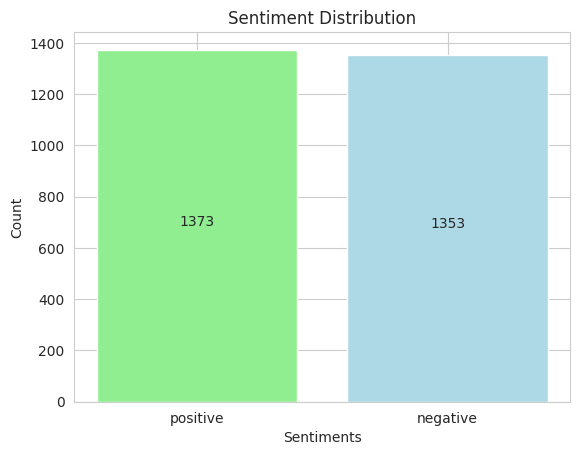

In [270]:
sentiment_counts = df['Sentiment'].value_counts()

color_list = ['lightgreen', 'lightblue']

plt.bar(sentiment_counts.index, sentiment_counts.values, color=color_list)
plt.xlabel('Sentiments')
plt.ylabel('Count')
plt.title('Sentiment Distribution')

for i, v in enumerate(sentiment_counts.values):
    plt.text(i, v/2, str(v), ha='center')

plt.show()

In [271]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2726 entries, 0 to 2725
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Reviews    2726 non-null   object
 1   Sentiment  2726 non-null   object
dtypes: object(2)
memory usage: 42.7+ KB


In [272]:
df.describe()

,Reviews,Sentiment
count,2726,2726
unique,2725,2
top,#ERROR!,positive
freq,2,1373


# Data Pre-processing

In [273]:
contractions = {
               "ain't": "am not / are not / is not / has not / have not", "aren't": "are not / am not", "can't": "cannot", "can't've": "cannot have", "'cause": "because", "could've": "could have", "couldn't": "could not",
               "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he'd": "he had / he would",
               "he'd've": "he would have", "he'll": "he shall / he will", "he'll've": "he shall have / he will have", "he's": "he has / he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how has / how is / how does",
               "I'd": "I had / I would", "I'd've": "I would have", "I'll": "I shall / I will", "I'll've": "I shall have / I will have", "I'm": "I am", "I've": "I have", "isn't": "is not", "it'd": "it had / it would", "it'd've": "it would have",
               "it'll": "it shall / it will", "it'll've": "it shall have / it will have", "it's": "it has / it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have",
               "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "n't" : "not","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
               "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she had / she would", "she'd've": "she would have", "she'll": "she shall / she will", "she'll've": "she shall have / she will have", "she's": "she has / she is",
               "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have","so's": "so as / so is","that'd": "that would / that had","that'd've": "that would have","that's": "that has / that is",
               "there'd": "there had / there would","there'd've": "there would have","there's": "there has / there is","they'd": "they had / they would","they'd've": "they would have","they'll": "they shall / they will","they'll've": "they shall have / they will have",
               "they're": "they are","they've": "they have","to've": "to have","wasn't": "was not","we'd": "we had / we would","we'd've": "we would have","we'll": "we will","we'll've": "we will have","we're": "we are","we've": "we have",
               "weren't": "were not","what'll": "what shall / what will","what'll've": "what shall have / what will have","what're": "what are","what's": "what has / what is","what've": "what have","when's": "when has / when is","when've": "when have",
               "where'd": "where did","where's": "where has / where is","where've": "where have","who'll": "who shall / who will","who'll've": "who shall have / who will have","who's": "who has / who is","who've": "who have","why's": "why has / why is",
               "why've": "why have","will've": "will have","won't": "will not","won't've": "will not have","would've": "would have","wouldn't": "would not","wouldn't've": "would not have","y'all": "you all","y'all'd": "you all would",
               "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you had / you would","you'd've": "you would have","you'll": "you shall / you will","you'll've": "you shall have / you will have",
               "you're": "you are","you've": "you have"
              }

def expand_contractions(text):
    words = word_tokenize(text)
    expanded_words = []
    for word in words:
        if word in contractions:
            expanded_words.append(contractions[word])
        else:
            expanded_words.append(word)
    expanded_text = ' '.join(expanded_words)
    return expanded_text


# LOWERCASING
df['Reviews'] = df['Reviews'].astype(str)
df['Reviews'] = df['Reviews'].str.lower()

# EXPAND CONTRACTIONS
df['expanded_column'] = df['Reviews'].apply(expand_contractions)

# TOKENIZATION
df['tokenized_column'] = df['expanded_column'].apply(word_tokenize)

print(df['tokenized_column'])


0       [so, there, is, no, way, for, me, to, plug, it...
1                    [good, case, ,, excellent, value, .]
2                           [great, for, the, jawbone, .]
3       [tied, to, charger, for, conversations, lastin...
4                                [the, mic, is, great, .]
                              ...                        
2721    [i, think, food, should, have, flavor, and, te...
2722                       [appetite, instantly, gone, .]
2723    [overall, i, was, not, impressed, and, would, ...
2724    [the, whole, experience, was, underwhelming, ,...
2725    [then, as, if, i, had, not, wasted, enough, of...
Name: tokenized_column, Length: 2726, dtype: object


In [274]:
# REMOVAL OF PUNCTUATIONS AND SPECIAL CHARACTERS
df['cleaned_column'] = df['tokenized_column'].apply(lambda x: [re.sub(r'[^\w\s]', '', word) for word in x])

# REMOVAL OF URLs
df['cleaned_column'] = df['cleaned_column'].apply(lambda x: [re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', word) for word in x if '!' not in word or word == '!'])

# REMOVAL OF NUMBERS
df['cleaned_column'] = df['cleaned_column'].apply(lambda x: [re.sub(r'\d+', '', word) for word in x])

# REMOVAL OF EXTRA WHITE SPACE
df['cleaned_column'] = df['cleaned_column'].apply(lambda x: [re.sub(r'\s+', ' ', word).strip() for word in x])

# STOP WORDS REMOVAL
stop_words = stopwords.words('english')
df['cleaned_column'] = df['cleaned_column'].apply(lambda x: [word for word in x if word not in stop_words])

# Print the 'cleaned_column' column
print(df['cleaned_column'])

0                [way, plug, us, unless, go, converter, ]
1                      [good, case, , excellent, value, ]
2                                      [great, jawbone, ]
3       [tied, charger, conversations, lasting, , minu...
4                                          [mic, great, ]
                              ...                        
2721            [think, food, flavor, texture, lacking, ]
2722                        [appetite, instantly, gone, ]
2723              [overall, impressed, would, go, back, ]
2724    [whole, experience, underwhelming, , think, go...
2725    [wasted, enough, life, , poured, salt, wound, ...
Name: cleaned_column, Length: 2726, dtype: object


In [275]:
#PART OF SPEECH TAGGING
tagged_comments = []
for comment in df['cleaned_column']:
    tagged_comment = nltk.pos_tag(comment)
    tagged_comments.append(tagged_comment)

df['tagged_column'] = tagged_comments
print(df['tagged_column'])

0       [(way, NN), (plug, NN), (us, PRP), (unless, IN...
1       [(good, JJ), (case, NN), (, NNP), (excellent, ...
2                    [(great, JJ), (jawbone, NN), (, NN)]
3       [(tied, VBN), (charger, NN), (conversations, N...
4                        [(mic, JJ), (great, JJ), (, NN)]
                              ...                        
2721    [(think, VB), (food, NN), (flavor, NN), (textu...
2722    [(appetite, RB), (instantly, RB), (gone, VBN),...
2723    [(overall, JJ), (impressed, VBD), (would, MD),...
2724    [(whole, JJ), (experience, NN), (underwhelming...
2725    [(wasted, VBN), (enough, JJ), (life, NN), (, N...
Name: tagged_column, Length: 2726, dtype: object


In [276]:
#LEMMATIZATION
lemmatizer = WordNetLemmatizer()
lemmatized_comments = []
pos_map = {'J': wordnet.ADJ, 'N': wordnet.NOUN, 'V': wordnet.VERB}

for tagged_comment in df['tagged_column']:
    lemmatized_comment = []
    for word, tag in tagged_comment:
        pos = pos_map.get(tag[0].upper(), 'n')
        lemmatized_word = lemmatizer.lemmatize(word, pos=pos)
        lemmatized_comment.append(lemmatized_word)
    lemmatized_comment_str = ' '.join(lemmatized_comment)
    lemmatized_comments.append(lemmatized_comment_str)

df['lemmatized_column'] = lemmatized_comments
print(df['lemmatized_column'])

0                         way plug u unless go converter 
1                             good case  excellent value 
2                                          great jawbone 
3       tie charger conversation last  minutesmajor pr...
4                                              mic great 
                              ...                        
2721                      think food flavor texture lack 
2722                               appetite instantly go 
2723                       overall impress would go back 
2724    whole experience underwhelming  think go ninja...
2725    waste enough life  pour salt wound draw time t...
Name: lemmatized_column, Length: 2726, dtype: object


# Feature Extraction

In [277]:
# TF-IDF
vectorize= TfidfVectorizer()
response= vectorize.fit_transform(df['lemmatized_column'])

print(response)

  (0, 798)	0.5877937415938245
  (0, 1615)	0.2937560514594589
  (0, 4013)	0.49818760389338557
  (0, 2813)	0.4347216376469669
  (0, 4176)	0.3619835751281907
  (1, 4072)	0.6250211360215425
  (1, 1291)	0.486214593264493
  (1, 549)	0.5079183490753233
  (1, 1624)	0.33906179303422285
  (2, 2008)	0.8983313769844299
  (2, 1650)	0.43931849167233816
  (3, 2896)	0.32577286831349417
  (3, 2383)	0.49164934992358517
  (3, 2103)	0.3429841083426505
  (3, 797)	0.4368301545932236
  (3, 595)	0.35389191378817814
  (3, 3830)	0.4673914695502187
  (4, 2358)	0.8929995893966787
  (4, 1650)	0.45005747781518224
  (5, 4134)	0.35357135114403737
  (5, 933)	0.3681891214192441
  (5, 3141)	0.3000057955985487
  (5, 2174)	0.3324278767338829
  (5, 1594)	0.4632600303388907
  (5, 2022)	0.45785984591337614
  :	:
  (2723, 259)	0.38701902111985026
  (2723, 1876)	0.5834015719710257
  (2723, 2640)	0.5042922179682402
  (2723, 4276)	0.3704194593676708
  (2723, 1615)	0.3440024216943894
  (2724, 2519)	0.45059745448708427
  (2724, 37

# Classification Model with Pre-processing

In [ ]:
# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(df['lemmatized_column'])
y = df['Sentiment']

selector = SelectKBest(chi2, k=1000)
X_new = selector.fit_transform(X, y)

# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

log_reg_model = LogisticRegression(max_iter=10000)
nb_model = MultinomialNB()
svm_model = SVC()
dt_model = DecisionTreeClassifier()
rf_model = RandomForestClassifier()

models_with_preprocess = {
    "Logistic Regression": log_reg_model,
    "Multinomial Naive Bayes" : nb_model,
    "Support Vector Machine": svm_model,
    "Decision Tree": dt_model,
    "Random Forest": rf_model,
}

# Train and evaluate models
results1 = {}
for name, model in models_with_preprocess.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    results1[name] = accuracy

# Print results
print("Model Accuracies With Pre-processing:")
for name, accuracy in results1.items():
    print(f"{name}: {accuracy*100:.2f}%")

Model Accuracies With Pre-processing:
Logistic Regression: 85.16%
Multinomial Naive Bayes: 85.90%
Support Vector Machine: 86.45%
Decision Tree: 73.08%
Random Forest: 78.21%


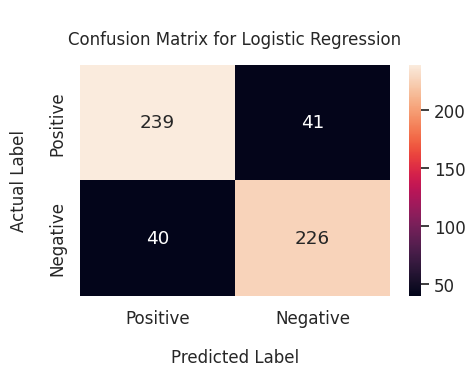

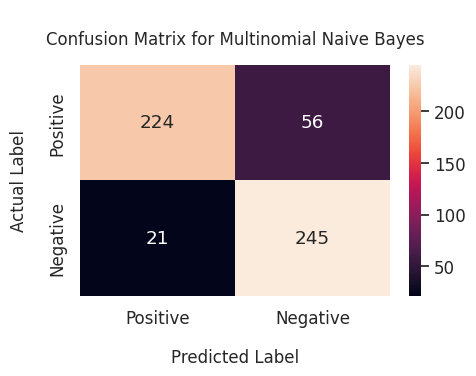

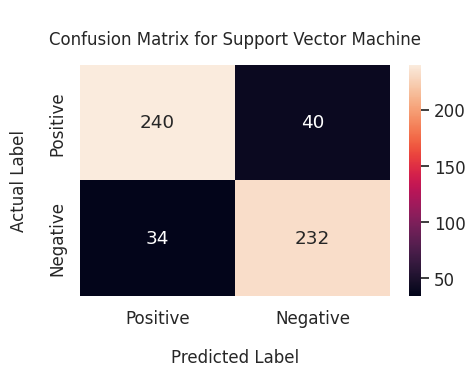

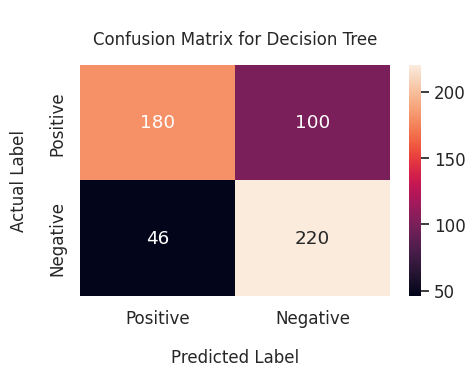

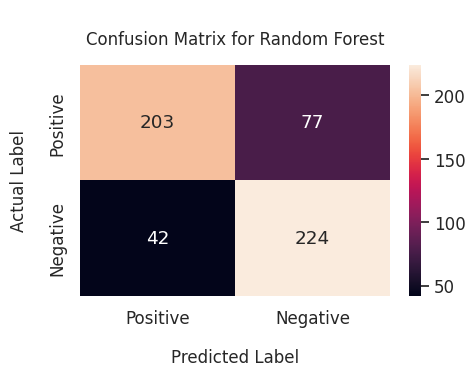

In [ ]:
for name, model in models_with_preprocess.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions)

    plt.figure(figsize=(5,3))
    sns.set(font_scale=1.1)
    ax = sns.heatmap(cm, annot=True, fmt='d')
    ax.set_xlabel("Predicted Label", fontsize=12, labelpad=15)
    ax.xaxis.set_ticklabels(['Positive', 'Negative'])
    ax.set_ylabel("Actual Label", fontsize=12, labelpad=15)
    ax.yaxis.set_ticklabels(['Positive', 'Negative'])
    ax.set_title(f"\nConfusion Matrix for {name}", fontsize=12, pad=15)
    plt.show()

In [ ]:
joblib.dump(models_with_preprocess, '/content/drive/MyDrive/Colab Notebooks/models1.pckl')
classification_model = joblib.load('/content/drive/MyDrive/Colab Notebooks/models1.pckl')
for name, model in classification_model.items():
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f"{name}: {accuracy*100:.2f}%")

Logistic Regression: 85.16%
Multinomial Naive Bayes: 85.90%
Support Vector Machine: 86.45%
Decision Tree: 73.26%
Random Forest: 78.21%


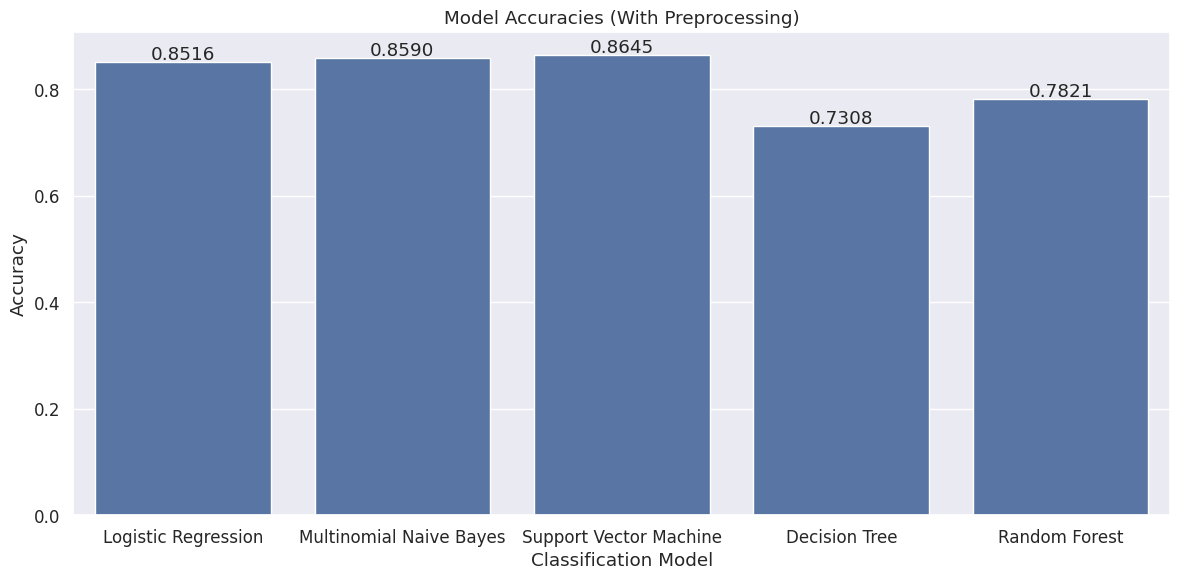

In [ ]:
def model_accuracies1(results1, figsize=(12, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    models = list(results1.keys())
    accuracies = list(results1.values())
    sns.barplot(x=models, y=accuracies, ax=ax )
    ax.set_xlabel("Classification Model")
    ax.set_ylabel("Accuracy")
    ax.set_title("Model Accuracies (With Preprocessing)")
    for i, accuracy in enumerate(accuracies):
        ax.text(i, accuracy + 0.005, f"{accuracy:.4f}", ha='center')

    plt.tight_layout()
    plt.show()

model_accuracies1(results1)

# Classification Model w/o Pre-processing

In [ ]:
vectorize= TfidfVectorizer()
response= vectorize.fit_transform(df['Reviews'])

X = response
y = df['Sentiment']

selector = SelectKBest(chi2, k=1000)
X_new = selector.fit_transform(X, y)

# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

log_reg_model = LogisticRegression(max_iter=10000)
nb_model = MultinomialNB()
svm_model = SVC()
dt_model = DecisionTreeClassifier()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

models_without_preprocess = {
    "Logistic Regression": log_reg_model,
    "Multinomial Naive Bayes" : nb_model,
    "Support Vector Machine": svm_model,
    "Decision Tree": dt_model,
    "Random Forest": rf_model,
}

# Train and evaluate models
results2 = {}
for name, model in models_without_preprocess.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    results2[name] = accuracy

# Print results
print("Model Accuracies Without Pre-processing:")
for name, accuracy in results2.items():
    print(f"{name}: {accuracy*100:.2f}%")

Model Accuracies Without Pre-processing:
Logistic Regression: 86.63%
Multinomial Naive Bayes: 88.64%
Support Vector Machine: 88.46%
Decision Tree: 74.73%
Random Forest: 81.50%


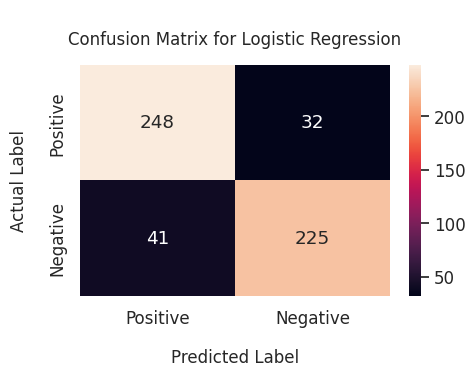

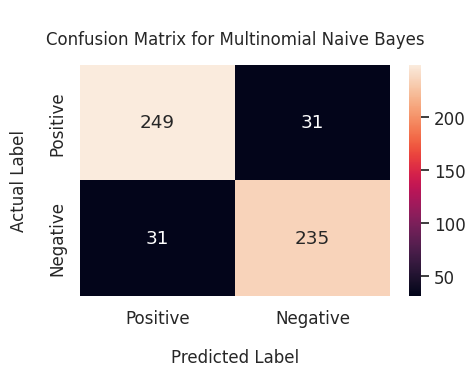

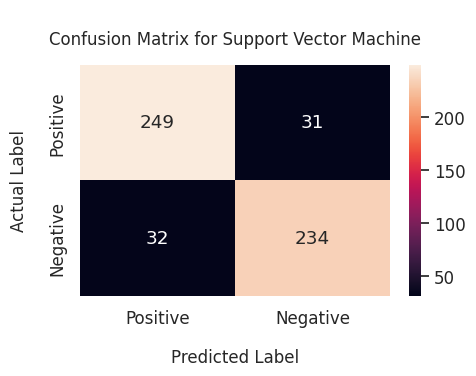

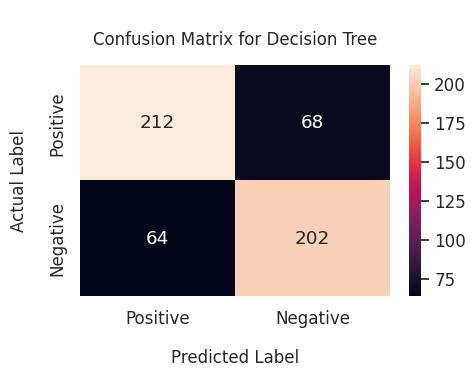

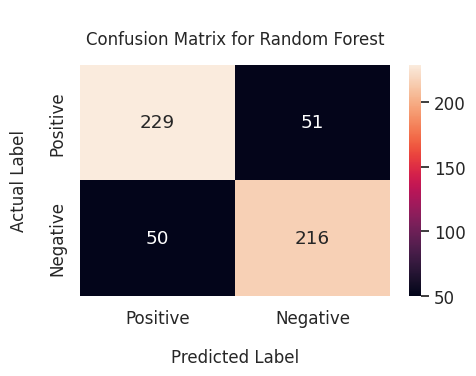

In [ ]:
for name, model in models_without_preprocess.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions)

    plt.figure(figsize=(5,3))
    sns.set(font_scale=1.1)
    ax = sns.heatmap(cm, annot=True, fmt='d')
    ax.set_xlabel("Predicted Label", fontsize=12, labelpad=15)
    ax.xaxis.set_ticklabels(['Positive', 'Negative'])
    ax.set_ylabel("Actual Label", fontsize=12, labelpad=15)
    ax.yaxis.set_ticklabels(['Positive', 'Negative'])
    ax.set_title(f"\nConfusion Matrix for {name}", fontsize=12, pad=15)
    plt.show()

In [ ]:
joblib.dump(models_without_preprocess, '/content/drive/MyDrive/Colab Notebooks/models2.pckl')
classification_model = joblib.load('/content/drive/MyDrive/Colab Notebooks/models2.pckl')
for name, model in classification_model.items():
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f"{name}: {accuracy*100:.2f}%")

Logistic Regression: 86.63%
Multinomial Naive Bayes: 88.64%
Support Vector Machine: 88.46%
Decision Tree: 75.82%
Random Forest: 81.50%


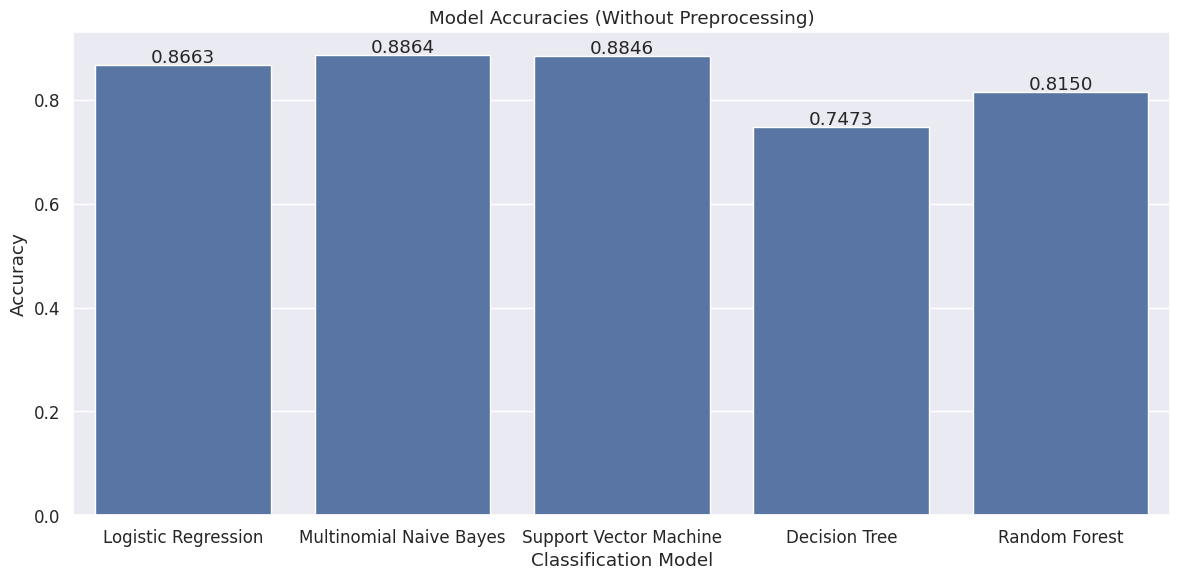

In [ ]:
def model_accuracies2(results2, figsize=(12, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    models = list(results2.keys())
    accuracies = list(results2.values())
    sns.barplot(x=models, y=accuracies, ax=ax )
    ax.set_xlabel("Classification Model")
    ax.set_ylabel("Accuracy")
    ax.set_title("Model Accuracies (Without Preprocessing)")
    for i, accuracy in enumerate(accuracies):
        ax.text(i, accuracy + 0.005, f"{accuracy:.4f}", ha='center')
    plt.tight_layout()
    plt.show()

model_accuracies2(results2)

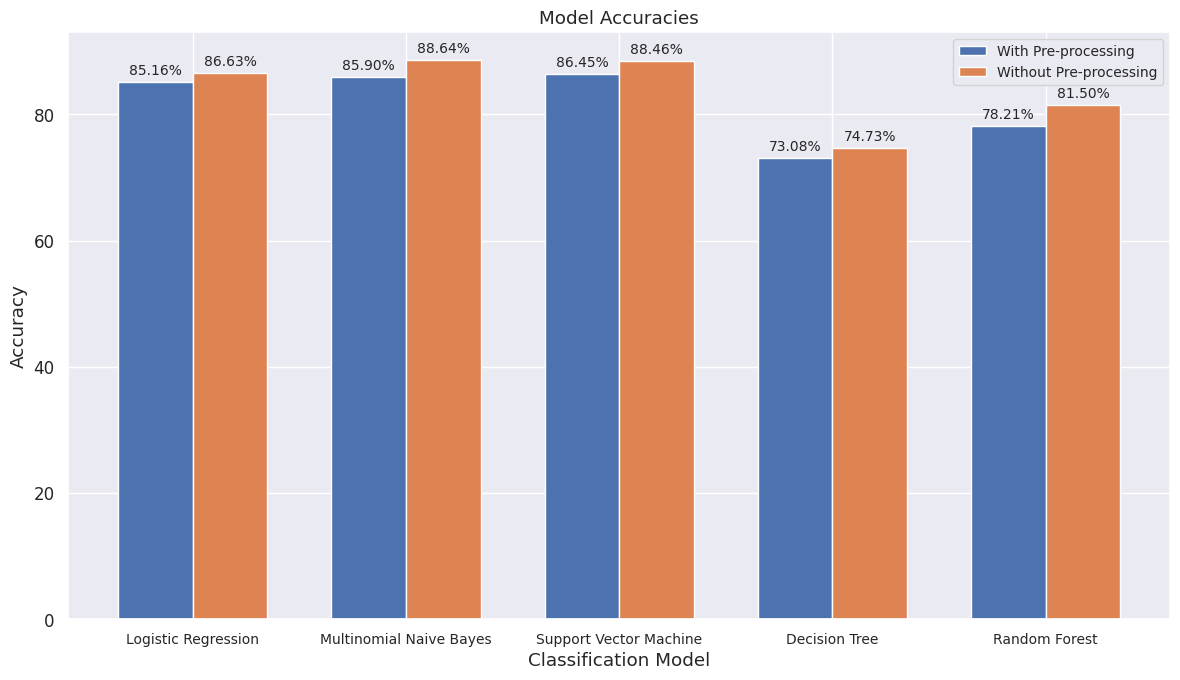

In [ ]:
def plot_model_accuracies(results1, results2, title1, title2):
    model_names = list(results1.keys())
    accuracies_with_preprocessing = [accuracy * 100 for accuracy in results1.values()]
    accuracies_without_preprocessing = [accuracy * 100 for accuracy in results2.values()]

    x = np.arange(len(model_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 7))
    accuracy1 = ax.bar(x - width/2, accuracies_with_preprocessing, width, label=title1)
    accuracy2 = ax.bar(x + width/2, accuracies_without_preprocessing, width, label=title2)

    ax.set_xlabel('Classification Model')
    ax.set_ylabel('Accuracy')
    ax.set_title('Model Accuracies')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, fontsize=10)
    ax.legend(fontsize=10)

    def model_accuracies(accuracy):
        for accuracy in accuracy:
            height = accuracy.get_height()
            ax.annotate(f'{height:.2f}%', xy=(accuracy.get_x() + accuracy.get_width()/2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)

    model_accuracies(accuracy1)
    model_accuracies(accuracy2)

    plt.tight_layout()
    plt.show()

plot_model_accuracies(results1, results2, "With Pre-processing", "Without Pre-processing")

# Hyperparameter Tuning - GridSearchCV - Individual Classifiers

In [ ]:
log_reg_model = LogisticRegression(random_state=42, solver='liblinear')
logreg_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10, 100, 1000],
}

logreg_grid_search = GridSearchCV(log_reg_model, logreg_param_grid, cv=10, scoring='f1_weighted', n_jobs=-1, verbose=2)
logreg_grid_search.fit(X_train, y_train)
print("Best hyperparameters: ", logreg_grid_search.best_params_)
y_pred = logreg_grid_search.best_estimator_.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best hyperparameters:  {'C': 10, 'penalty': 'l2'}
              precision    recall  f1-score   support

    negative       0.87      0.89      0.88       280
    positive       0.88      0.86      0.87       266

    accuracy                           0.87       546
   macro avg       0.87      0.87      0.87       546
weighted avg       0.87      0.87      0.87       546



In [ ]:
joblib.dump(logreg_grid_search.best_estimator_, '/content/drive/MyDrive/Colab Notebooks/logreg_model.pckl')
loaded_model_joblib = joblib.load('/content/drive/MyDrive/Colab Notebooks/logreg_model.pckl')
predictions = loaded_model_joblib.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Logistic Regression: {accuracy*100:.2f}%")

Logistic Regression: 87.18%


In [ ]:
mnb_param_grid = {
    'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    'fit_prior': [True, False]
}

mnb_grid_search = GridSearchCV(nb_model, mnb_param_grid, cv=10, scoring='f1_weighted', n_jobs=-1, verbose=2)
mnb_grid_search.fit(X_train, y_train)
print("Best hyperparameters: ", mnb_grid_search.best_params_)
y_pred = mnb_grid_search.best_estimator_.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best hyperparameters:  {'alpha': 0.0001, 'fit_prior': False}
              precision    recall  f1-score   support

    negative       0.90      0.91      0.90       280
    positive       0.91      0.89      0.90       266

    accuracy                           0.90       546
   macro avg       0.90      0.90      0.90       546
weighted avg       0.90      0.90      0.90       546



In [ ]:
joblib.dump(mnb_grid_search.best_estimator_, '/content/drive/MyDrive/Colab Notebooks/nb_model.pckl')
loaded_model_joblib = joblib.load('/content/drive/MyDrive/Colab Notebooks/nb_model.pckl')
predictions = loaded_model_joblib.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Naive Bayes: {accuracy*100:.2f}%")

Naive Bayes: 90.11%


In [ ]:
svm_param_grid = {
    'C':[0.01,0.1,1,10],
    'kernel' : ["linear","poly","rbf","sigmoid"],
    'degree' : [1,3,5],
    'gamma' : [0.01,1,10]
}

svm_grid_search = GridSearchCV(svm_model, svm_param_grid, cv=10, scoring='f1_weighted', n_jobs=-1, verbose=2)
svm_grid_search.fit(X_train, y_train)
print("Best hyperparameters: ", svm_grid_search.best_params_)
y_pred = svm_grid_search.best_estimator_.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Best hyperparameters:  {'C': 1, 'degree': 1, 'gamma': 1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

    negative       0.88      0.89      0.88       280
    positive       0.88      0.87      0.88       266

    accuracy                           0.88       546
   macro avg       0.88      0.88      0.88       546
weighted avg       0.88      0.88      0.88       546



In [ ]:
joblib.dump(svm_grid_search.best_estimator_, '/content/drive/MyDrive/Colab Notebooks/svm_model.pckl')
loaded_model_joblib = joblib.load('/content/drive/MyDrive/Colab Notebooks/svm_model.pckl')
predictions = loaded_model_joblib.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"SVM: {accuracy*100:.2f}%")

SVM: 87.91%


In [ ]:
dt_param_grid = {
    'criterion':['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_grid_search = GridSearchCV(dt_model, dt_param_grid, cv=10, scoring='f1_weighted', n_jobs=-1, verbose=2)
dt_grid_search.fit(X_train, y_train)
print("Best hyperparameters: ", dt_grid_search.best_params_)
y_pred = dt_grid_search.best_estimator_.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

Fitting 10 folds for each of 72 candidates, totalling 720 fits
Best hyperparameters:  {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
              precision    recall  f1-score   support

    negative       0.76      0.78      0.77       280
    positive       0.76      0.74      0.75       266

    accuracy                           0.76       546
   macro avg       0.76      0.76      0.76       546
weighted avg       0.76      0.76      0.76       546



In [ ]:
joblib.dump(dt_grid_search.best_estimator_, '/content/drive/MyDrive/Colab Notebooks/dt_model.pckl')
loaded_model_joblib = joblib.load('/content/drive/MyDrive/Colab Notebooks/dt_model.pckl')
predictions = loaded_model_joblib.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Decision Tree: {accuracy*100:.2f}%")

Decision Tree: 76.37%


In [ ]:
rf_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 20, 40, 60],
    'max_features' : ['log2', 'sqrt'],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=10, scoring='f1_weighted', n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train, y_train)
print("Best hyperparameters: ", rf_grid_search.best_params_)
y_pred = rf_grid_search.best_estimator_.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

Fitting 10 folds for each of 96 candidates, totalling 960 fits
Best hyperparameters:  {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}
              precision    recall  f1-score   support

    negative       0.82      0.83      0.83       280
    positive       0.82      0.81      0.82       266

    accuracy                           0.82       546
   macro avg       0.82      0.82      0.82       546
weighted avg       0.82      0.82      0.82       546



In [ ]:
joblib.dump(rf_grid_search.best_estimator_, '/content/drive/MyDrive/Colab Notebooks/rf_model.pckl')
loaded_model_joblib = joblib.load('/content/drive/MyDrive/Colab Notebooks/rf_model.pckl')
predictions = loaded_model_joblib.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Random Forest: {accuracy*100:.2f}%")

Random Forest: 82.23%


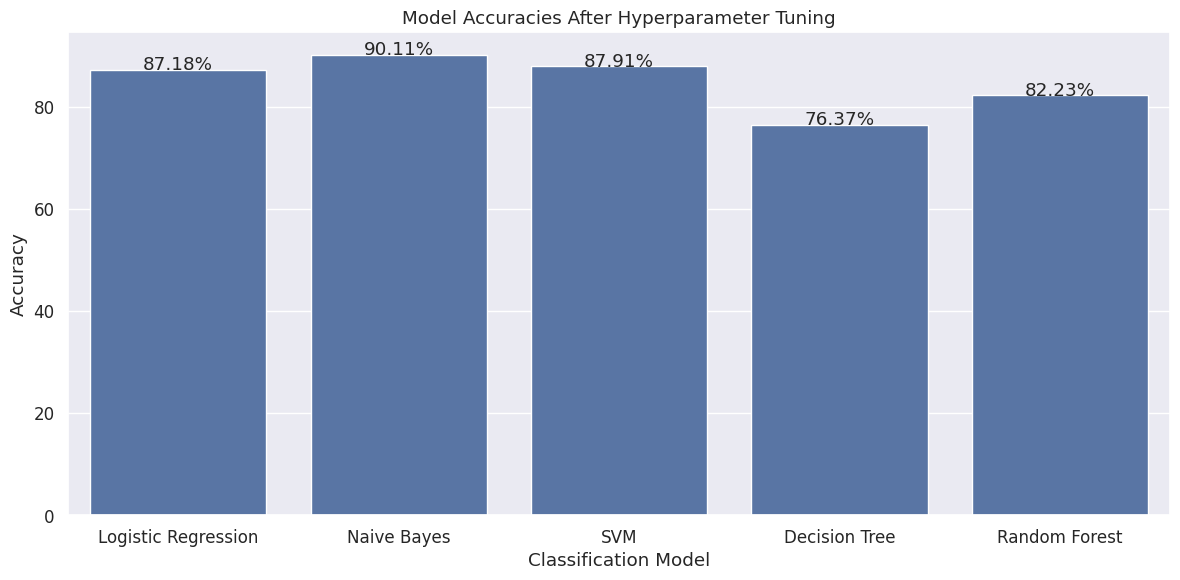

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
models = ['Logistic Regression', 'Naive Bayes', 'SVM', 'Decision Tree', 'Random Forest']
accuracies = [accuracy*100 for accuracy in [
    loaded_model_joblib.score(X_test, y_test) for loaded_model_joblib in [
        joblib.load('/content/drive/MyDrive/Colab Notebooks/logreg_model.pckl'),
        joblib.load('/content/drive/MyDrive/Colab Notebooks/nb_model.pckl'),
        joblib.load('/content/drive/MyDrive/Colab Notebooks/svm_model.pckl'),
        joblib.load('/content/drive/MyDrive/Colab Notebooks/dt_model.pckl'),
        joblib.load('/content/drive/MyDrive/Colab Notebooks/rf_model.pckl')
    ]
]]
sns.barplot(x=models, y=accuracies, ax=ax)
sns.set_style("whitegrid")
ax.set_xlabel('Classification Model')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracies After Hyperparameter Tuning')

for i, accuracy in enumerate(accuracies):
    ax.text(i, accuracy + 0.005, f"{accuracy:.2f}%", ha='center')

plt.tight_layout()
plt.show()

# Ensemble Model - Voting Classifiier

In [20]:
vectorize= TfidfVectorizer()
response= vectorize.fit_transform(df['Reviews'])

X = response
y = df['Sentiment']

# Apply feature selection on the dataset
selector = SelectKBest(chi2, k=1000)
X_new = selector.fit_transform(X, y)

# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

log_reg_model = LogisticRegression(random_state=42, solver='liblinear', C= 10, penalty= 'l2')
mnb_model = MultinomialNB(alpha=0.0001, fit_prior=False)
svm_model = SVC(C=1, degree= 1, gamma= 1, probability=True, kernel= 'rbf')
dt_model = DecisionTreeClassifier(criterion= 'gini', max_depth= None, min_samples_leaf= 1, min_samples_split= 10)
rf_model = RandomForestClassifier(max_depth= None, max_features= 'log2', min_samples_leaf= 2, min_samples_split= 5, n_estimators= 500)

# Create a VotingClassifier
ensemble_without_preprocess = VotingClassifier(estimators=[('logreg', log_reg_model),
                                            ('mnb', mnb_model),
                                            ('svm', svm_model),
                                            ('dt', dt_model),
                                            ('rf', rf_model)],
                                              voting='soft')

ensemble_without_preprocess.fit(X_train, y_train)
y_pred = ensemble_without_preprocess.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))
print("Ensemble Classifier accuracy:", ensemble_without_preprocess.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       280
           1       0.88      0.86      0.87       266

    accuracy                           0.88       546
   macro avg       0.88      0.88      0.88       546
weighted avg       0.88      0.88      0.88       546

Ensemble Classifier accuracy: 0.8754578754578755


In [21]:
joblib.dump(ensemble_without_preprocess, '/content/drive/MyDrive/Colab Notebooks/voting_model.pckl')
loaded_model_joblib = joblib.load('/content/drive/MyDrive/Colab Notebooks/voting_model.pckl')
predictions = loaded_model_joblib.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Ensemble Model without Pre-processing: {accuracy*100:.2f}%")

Ensemble Model without Pre-processing: 87.55%


# Ensemble Model - Stacking Classifier

In [245]:
label_dict = {'positive': 1, 'negative': 0}
df['Sentiment'] = df['Sentiment'].map(label_dict)

vectorize= TfidfVectorizer()
response= vectorize.fit_transform(df['Reviews'])
X = response
y = df['Sentiment']

# Apply feature selection on the dataset
selector = SelectKBest(chi2, k=1000)
X_new = selector.fit_transform(X, y)

# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

log_reg_model = LogisticRegression(random_state=42, solver='liblinear', C= 10, penalty= 'l2')
mnb_model = MultinomialNB(alpha=0.0001, fit_prior=False)
svm_model = SVC(C=1, degree= 1, gamma= 1, probability=True, kernel= 'rbf')
dt_model = DecisionTreeClassifier(criterion= 'gini', max_depth= None, min_samples_leaf= 1, min_samples_split= 10)
rf_model = RandomForestClassifier(max_depth= None, max_features= 'log2', min_samples_leaf= 2, min_samples_split= 5, n_estimators= 500)

ensemble_without_preprocess = StackingClassifier(classifiers=[log_reg_model, mnb_model, svm_model, dt_model, rf_model],
                                                  meta_classifier=LogisticRegression())

ensemble_without_preprocess.fit(X_train, y_train)
y_pred = ensemble_without_preprocess.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))
print("Ensemble Classifier accuracy:", ensemble_without_preprocess.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.85      0.76      0.80       280
           1       0.78      0.86      0.81       266

    accuracy                           0.81       546
   macro avg       0.81      0.81      0.81       546
weighted avg       0.81      0.81      0.81       546

Ensemble Classifier accuracy: 0.8095238095238095


In [246]:
joblib.dump(ensemble_without_preprocess, '/content/drive/MyDrive/Colab Notebooks/stacking_model.pckl')
loaded_model_joblib = joblib.load('/content/drive/MyDrive/Colab Notebooks/stacking_model.pckl')
predictions = loaded_model_joblib.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Ensemble Model without Pre-processing: {accuracy*100:.2f}%")

Ensemble Model without Pre-processing: 80.95%


# Ensemble Model - Boosting Classifier

In [262]:
label_dict = {'positive': 1, 'negative': 0}
df['Sentiment'] = df['Sentiment'].map(label_dict)

vectorize= TfidfVectorizer()
response= vectorize.fit_transform(df['Reviews'])
X = response
y = df['Sentiment']

# Apply feature selection on the dataset
selector = SelectKBest(chi2, k=1000)
X_new = selector.fit_transform(X, y)

# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

log_reg_model = LogisticRegression(random_state=42, solver='liblinear', C= 10, penalty= 'l2')
mnb_model = MultinomialNB(alpha=0.0001, fit_prior=False)
svm_model = SVC(C=1, degree= 1, gamma= 1, probability=True, kernel= 'rbf')
dt_model = DecisionTreeClassifier(criterion= 'gini', max_depth= None, min_samples_leaf= 1, min_samples_split= 10)
rf_model = RandomForestClassifier(max_depth= None, max_features= 'log2', min_samples_leaf= 2, min_samples_split= 5, n_estimators= 500)

ensemble_without_preprocess = AdaBoostClassifier(base_estimator=log_reg_model, n_estimators=50, learning_rate=0.1)

ensemble_without_preprocess.fit(X_train, y_train)
y_pred = ensemble_without_preprocess.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))
print("Ensemble Classifier accuracy:", ensemble_without_preprocess.score(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.86      0.59      0.70       280
           1       0.68      0.90      0.77       266

    accuracy                           0.74       546
   macro avg       0.77      0.75      0.74       546
weighted avg       0.77      0.74      0.74       546

Ensemble Classifier accuracy: 0.7435897435897436


In [263]:
joblib.dump(ensemble_without_preprocess, '/content/drive/MyDrive/Colab Notebooks/boosting_model.pckl')
loaded_model_joblib = joblib.load('/content/drive/MyDrive/Colab Notebooks/boosting_model.pckl')
predictions = loaded_model_joblib.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Ensemble Model without Pre-processing: {accuracy*100:.2f}%")

Ensemble Model without Pre-processing: 74.36%


# Ensemble Model - Bagging Classifier

In [278]:
label_dict = {'positive': 1, 'negative': 0}
df['Sentiment'] = df['Sentiment'].map(label_dict)

vectorize= TfidfVectorizer()
response= vectorize.fit_transform(df['Reviews'])
X = response
y = df['Sentiment']

# Apply feature selection on the dataset
selector = SelectKBest(chi2, k=1000)
X_new = selector.fit_transform(X, y)

# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

log_reg_model = LogisticRegression(random_state=42, solver='liblinear', C= 10, penalty= 'l2')
mnb_model = MultinomialNB(alpha=0.0001, fit_prior=False)
svm_model = SVC(C=1, degree= 1, gamma= 1, probability=True, kernel= 'rbf')
dt_model = DecisionTreeClassifier(criterion= 'gini', max_depth= None, min_samples_leaf= 1, min_samples_split= 10)
rf_model = RandomForestClassifier(max_depth= None, max_features= 'log2', min_samples_leaf= 2, min_samples_split= 5, n_estimators= 500)

ensemble_without_preprocess = BaggingClassifier(base_estimator=log_reg_model, n_estimators=50)
ensemble_without_preprocess.fit(X_train, y_train)
y_pred = ensemble_without_preprocess.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))
print("Ensemble Classifier accuracy:", ensemble_without_preprocess.score(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.86      0.88      0.87       280
           1       0.87      0.85      0.86       266

    accuracy                           0.87       546
   macro avg       0.87      0.87      0.87       546
weighted avg       0.87      0.87      0.87       546

Ensemble Classifier accuracy: 0.8681318681318682


In [280]:
joblib.dump(ensemble_without_preprocess, '/content/drive/MyDrive/Colab Notebooks/bagging_model.pckl')
loaded_model_joblib = joblib.load('/content/drive/MyDrive/Colab Notebooks/bagging_model.pckl')
predictions = loaded_model_joblib.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Ensemble Model without Pre-processing: {accuracy*100:.2f}%")

Ensemble Model without Pre-processing: 86.81%


# Summary

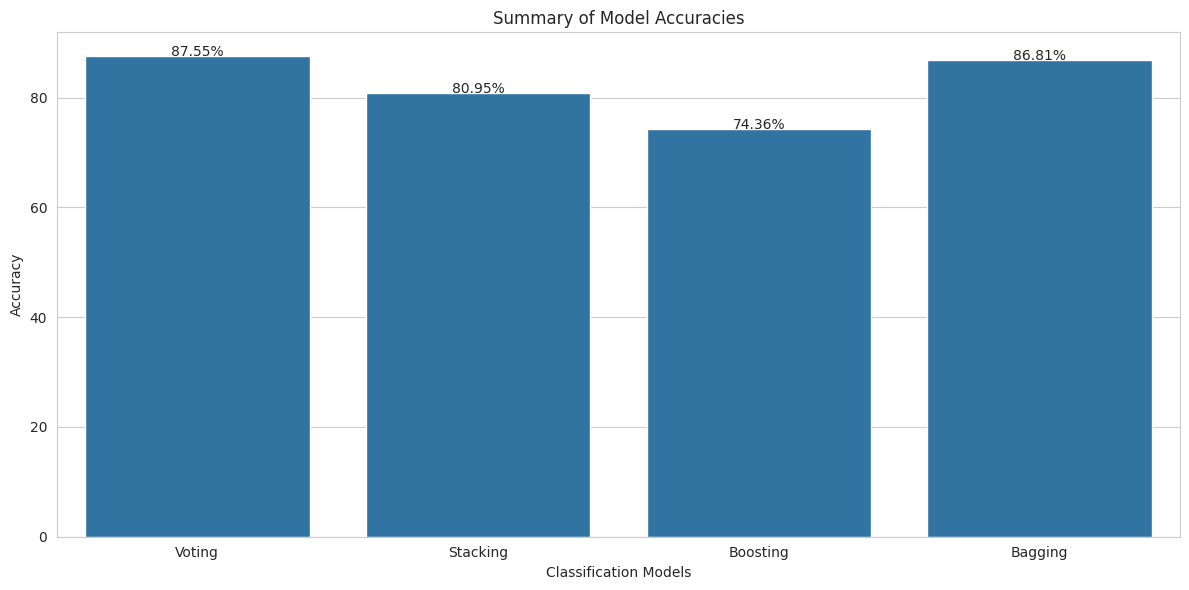

In [282]:
fig, ax = plt.subplots(figsize=(12, 6))
models = ['Voting', 'Stacking', 'Boosting', 'Bagging']
accuracies = [accuracy*100 for accuracy in [
    loaded_model_joblib.score(X_test, y_test) for loaded_model_joblib in [
        joblib.load('/content/drive/MyDrive/Colab Notebooks/voting_model.pckl'),
        joblib.load('/content/drive/MyDrive/Colab Notebooks/stacking_model.pckl'),
        joblib.load('/content/drive/MyDrive/Colab Notebooks/boosting_model.pckl'),
        joblib.load('/content/drive/MyDrive/Colab Notebooks/bagging_model.pckl')
    ]
]]
sns.barplot(x=models, y=accuracies, ax=ax)
sns.set_style("whitegrid")
ax.set_xlabel('Ensemble Models')
ax.set_ylabel('Accuracy')
ax.set_title('Summary of Model Accuracies')

for i, accuracy in enumerate(accuracies):
    ax.text(i, accuracy + 0.005, f"{accuracy:.2f}%", ha='center')

plt.tight_layout()
plt.show()